# Initial Test of Facial Keypoint Detector
## Without PCA and an SVM for each class

First we need to identify the keypoint detector model that we will be using. 

MTCNN - Tensorflow
https://github.com/ipazc/mtcnn
(Appears to be pretrained)
It appears to provide a few facial keypoints. May be useful for patch based approach probably not for direct-point position approach.

Pytorch-Facial-Keypoints - Pytorch
https://github.com/fiyero/pytorch_facial_keypoints
(Not pretrained)
Generates keypoints around face but excludes ears. Can be used for direct-point position approach.

Openface - in Lua?
https://github.com/cmusatyalab/openface
(Might be pretrained)
Not sure if it generates keypoints

Openface - 
https://github.com/TadasBaltrusaitis/OpenFace
(Pretrained models)
High number of facial points. Can be used for direct-point position approach.

Facial-Landmark
https://github.com/huohuotm/Facial-Landmark
(pretrained models)
High number of facial points. Can be used for direct-point position approach.

Face-Recognition
https://github.com/ageitgey/face_recognition
(Is pretrained and comes as a library)
Detects facial points.

## Preprocessing images
TODO ?

## Processing on keypoints
TODO ?

## For the classifier
https://scikit-learn.org/stable/modules/svm.html
Recommend Linear SVC first

# The Plan
I am planning on using Face-Recognition which provides a wrapper around dlib face-keypoint-detector. (If we wanted to we could write our own).

Program will read in image, run face-recog for key-points, and store key-points in a CSV file.

Then using the key-points

# Second approach is an end-to-end solution

Something akin to https://github.com/ZER-0-NE/ML_problems

In [1]:
import face_recognition
image = face_recognition.load_image_file("./data/raw/Test/22q11/image_10008_jpg.jpg")
face_landmarks_list = face_recognition.face_landmarks(image)

print(image.shape)
print(face_landmarks_list)

(600, 800, 3)
[{'chin': [(340, 262), (322, 300), (308, 341), (298, 384), (295, 427), (301, 470), (314, 507), (330, 541), (357, 564), (394, 575), (433, 567), (470, 553), (502, 532), (529, 505), (552, 476), (575, 445), (596, 411)], 'left_eyebrow': [(372, 250), (395, 243), (420, 254), (440, 272), (455, 294)], 'right_eyebrow': [(497, 323), (526, 329), (552, 340), (572, 360), (578, 386)], 'nose_bridge': [(459, 338), (445, 365), (431, 391), (417, 420)], 'nose_tip': [(383, 417), (393, 429), (406, 442), (424, 445), (442, 446)], 'left_eye': [(384, 286), (401, 284), (419, 295), (424, 319), (407, 314), (391, 303)], 'right_eye': [(492, 364), (512, 359), (530, 370), (539, 390), (522, 390), (504, 380)], 'top_lip': [(347, 452), (368, 456), (387, 464), (398, 474), (414, 477), (433, 489), (450, 500), (441, 498), (408, 487), (393, 482), (382, 475), (354, 458)], 'bottom_lip': [(450, 500), (423, 508), (398, 506), (382, 500), (369, 491), (356, 475), (347, 452), (354, 458), (379, 478), (391, 486), (406, 491

In [2]:
from PIL import Image, ImageDraw
import face_recognition

# Load the jpg file into a numpy array
image = face_recognition.load_image_file("./data/raw/Test/Angelman/image_161_jpg.jpg")

# Find all facial features in all the faces in the image
face_landmarks_list = face_recognition.face_landmarks(image)

pil_image = Image.fromarray(image)
for face_landmarks in face_landmarks_list:
    d = ImageDraw.Draw(pil_image, 'RGBA')

    # Make the eyebrows into a nightmare
    d.polygon(face_landmarks['left_eyebrow'], fill=(68, 54, 39, 128))
    d.polygon(face_landmarks['right_eyebrow'], fill=(68, 54, 39, 128))
    d.line(face_landmarks['left_eyebrow'], fill=(68, 54, 39, 150), width=5)
    d.line(face_landmarks['right_eyebrow'], fill=(68, 54, 39, 150), width=5)

    # Gloss the lips
    d.polygon(face_landmarks['top_lip'], fill=(150, 0, 0, 128))
    d.polygon(face_landmarks['bottom_lip'], fill=(150, 0, 0, 128))
    d.line(face_landmarks['top_lip'], fill=(150, 0, 0, 64), width=8)
    d.line(face_landmarks['bottom_lip'], fill=(150, 0, 0, 64), width=8)

    # Sparkle the eyes
    d.polygon(face_landmarks['left_eye'], fill=(255, 255, 255, 30))
    d.polygon(face_landmarks['right_eye'], fill=(255, 255, 255, 30))

    # Apply some eyeliner
    d.line(face_landmarks['left_eye'] + [face_landmarks['left_eye'][0]], fill=(0, 0, 0, 110), width=6)
    d.line(face_landmarks['right_eye'] + [face_landmarks['right_eye'][0]], fill=(0, 0, 0, 110), width=6)

    pil_image.show()

In [3]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
X, y = make_classification(n_features=4, random_state=0)
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X, y)
print(clf.coef_)
print(clf.intercept_)
print(clf.predict([[0, 0, 0, 0]]))

[[0.08551853 0.39414771 0.49848086 0.37514369]]
[0.28417571]
[1]


# Load image and generate landmarks

In [4]:
import os
import numpy as np
import face_recognition

LABELS = ['22q11','Angelman','Apert','CDL','Down','FragileX','Marfan','Progeria','Sotos','TreacherCollins','Turner','Williams']


def load_dataset(setPath):
    X = []
    y = []

    for label in LABELS:
        directory = os.path.join(setPath,label)
        for f in os.listdir(directory):
            path = os.path.join(directory,f)
            
            if os.path.isfile(path) and f != 'desktop.ini':
                
                # Extract landmarks
                image = face_recognition.load_image_file(path)
                face_landmarks_list = face_recognition.face_landmarks(image)

                # Iterate through detected faces
                keypoints = []
                for face in face_landmarks_list:

                    # Get face center
                    # and convert points into list form
                    cX = 0
                    cY = 0
                    count = 0
                    points = []

                    for featureType in face.keys():
                        for point in face[featureType]:
                            points = points + list(point)

                            cY = cY + point[0]
                            cX = cX + point[1]
                            count = count + 1
                    cX = cX / count
                    cY = cY / count

                    # Center all points
                    for i in range(0,len(points)):
                        if i % 2 == 0:
                            points[i] = points[i] - cY
                        else:
                            points[i] = points[i] - cX

                    # Store result
                    keypoints.append(points)

                # Append to dataset
                for facePoints in keypoints:
                    X.append(facePoints)
                    y.append(label)
    
    return np.array(X), np.array(y)

In [5]:
X_test, y_test = load_dataset('./data/raw/Test')
print(X_test.shape)
print(y_test.shape)

(312, 144)
(312,)


In [6]:
X_train, y_train = load_dataset('./data/raw/Train')
print(X_train.shape)
print(y_train.shape)

(1023, 144)
(1023,)


SVM Approach

In [7]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5, max_iter=10000)
clf.fit(X_train, y_train)
print(clf.coef_)
print(clf.intercept_)

[[ 0.10019801  0.02033238 -0.01293501 ...  0.10311704  0.00382582
  -0.02161245]
 [ 0.04627985 -0.2164234  -0.06763444 ... -0.27987202  0.17123591
   0.09595782]
 [-0.11685209  0.16818827 -0.19210823 ... -0.18054411  0.03257562
  -0.21174519]
 ...
 [ 0.15712787 -0.12318642 -0.12833338 ... -0.25078485 -0.09366315
   0.11903913]
 [ 0.01596341  0.19515915  0.06042189 ... -0.18533853  0.06344362
  -0.02838656]
 [-0.02840746 -0.19262492  0.00243679 ...  0.01597841 -0.16346589
  -0.08416011]]
[-0.27810576 -1.24598348 -0.49805885 -0.92951409 -1.10971039  0.15390712
 -0.36607845 -0.44500052 -0.08861473 -0.75795422  0.08240735 -0.3952285 ]


/home/curt/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_train)

accuracy = accuracy_score(y_train, y_pred, normalize=False) / float(y_train.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_train,y_pred)

accuracy 0.7565982404692082


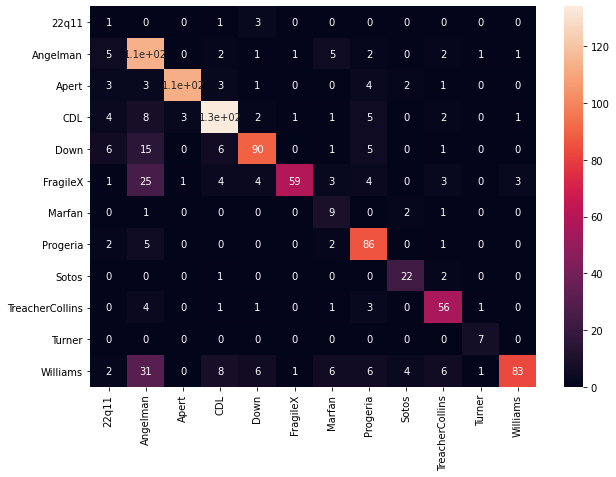

In [9]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred, normalize=False) / float(y_test.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_test,y_pred)

accuracy 0.5288461538461539


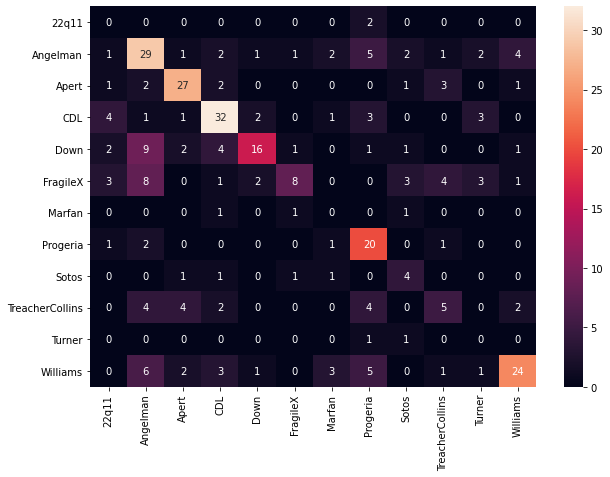

In [11]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

Neural Network Approach

In [12]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 50), max_iter=2000, verbose=True, n_iter_no_change=500)
clf.fit(X_train, y_train)

Iteration 1, loss = 26.59358291
Iteration 2, loss = 9.14019683
Iteration 3, loss = 5.77920773
Iteration 4, loss = 4.28264576
Iteration 5, loss = 3.68900138
Iteration 6, loss = 3.42295103
Iteration 7, loss = 3.02491688
Iteration 8, loss = 3.00347515
Iteration 9, loss = 2.71688585
Iteration 10, loss = 2.52605125
Iteration 11, loss = 2.48256710
Iteration 12, loss = 2.50116867
Iteration 13, loss = 2.39766840
Iteration 14, loss = 2.35542842
Iteration 15, loss = 2.25908045
Iteration 16, loss = 2.28701932
Iteration 17, loss = 2.42293014
Iteration 18, loss = 2.25452199
Iteration 19, loss = 2.23207047
Iteration 20, loss = 2.15631345
Iteration 21, loss = 2.19210937
Iteration 22, loss = 2.23530456
Iteration 23, loss = 2.17847136
Iteration 24, loss = 2.18749770
Iteration 25, loss = 2.21120780
Iteration 26, loss = 2.15132691
Iteration 27, loss = 2.15006973
Iteration 28, loss = 2.07179179
Iteration 29, loss = 2.05197088
Iteration 30, loss = 2.02334712
Iteration 31, loss = 2.10883824
Iteration 32, lo

Iteration 260, loss = 1.32375259
Iteration 261, loss = 1.26439851
Iteration 262, loss = 1.22325726
Iteration 263, loss = 1.21494347
Iteration 264, loss = 1.36223927
Iteration 265, loss = 1.40489469
Iteration 266, loss = 1.29928868
Iteration 267, loss = 1.29919320
Iteration 268, loss = 1.27798626
Iteration 269, loss = 1.27669953
Iteration 270, loss = 1.28324013
Iteration 271, loss = 1.22706120
Iteration 272, loss = 1.32956127
Iteration 273, loss = 1.33150499
Iteration 274, loss = 1.31503239
Iteration 275, loss = 1.26812896
Iteration 276, loss = 1.23048222
Iteration 277, loss = 1.19125786
Iteration 278, loss = 1.20894829
Iteration 279, loss = 1.22362855
Iteration 280, loss = 1.30594930
Iteration 281, loss = 1.28710451
Iteration 282, loss = 1.33464908
Iteration 283, loss = 1.25396101
Iteration 284, loss = 1.22694637
Iteration 285, loss = 1.28505576
Iteration 286, loss = 1.53953151
Iteration 287, loss = 1.55114878
Iteration 288, loss = 1.40308338
Iteration 289, loss = 1.35238994
Iteration 

Iteration 511, loss = 1.04910103
Iteration 512, loss = 1.06918710
Iteration 513, loss = 0.97242979
Iteration 514, loss = 0.98816243
Iteration 515, loss = 0.95783351
Iteration 516, loss = 0.92279671
Iteration 517, loss = 0.92867266
Iteration 518, loss = 0.93335044
Iteration 519, loss = 0.92826264
Iteration 520, loss = 0.91616091
Iteration 521, loss = 0.97261231
Iteration 522, loss = 1.05918668
Iteration 523, loss = 0.97319565
Iteration 524, loss = 0.96668923
Iteration 525, loss = 0.98786354
Iteration 526, loss = 1.00037654
Iteration 527, loss = 0.98437441
Iteration 528, loss = 0.97092385
Iteration 529, loss = 0.97349352
Iteration 530, loss = 0.97247145
Iteration 531, loss = 0.92100834
Iteration 532, loss = 0.90159895
Iteration 533, loss = 0.95447661
Iteration 534, loss = 0.89614573
Iteration 535, loss = 0.88171844
Iteration 536, loss = 0.87293060
Iteration 537, loss = 0.88484507
Iteration 538, loss = 0.91700689
Iteration 539, loss = 0.93194607
Iteration 540, loss = 0.87959925
Iteration 

Iteration 763, loss = 1.00513198
Iteration 764, loss = 1.03648458
Iteration 765, loss = 0.91082822
Iteration 766, loss = 0.83602590
Iteration 767, loss = 0.78310791
Iteration 768, loss = 0.74236080
Iteration 769, loss = 0.83562883
Iteration 770, loss = 0.82531928
Iteration 771, loss = 0.77907718
Iteration 772, loss = 0.83822494
Iteration 773, loss = 0.73118640
Iteration 774, loss = 0.74106405
Iteration 775, loss = 0.74977453
Iteration 776, loss = 0.74982791
Iteration 777, loss = 0.71568461
Iteration 778, loss = 0.69324631
Iteration 779, loss = 0.68269921
Iteration 780, loss = 0.68180773
Iteration 781, loss = 0.69714763
Iteration 782, loss = 0.67773520
Iteration 783, loss = 0.73980984
Iteration 784, loss = 0.70642152
Iteration 785, loss = 0.68251047
Iteration 786, loss = 0.66845810
Iteration 787, loss = 0.66923729
Iteration 788, loss = 0.71861346
Iteration 789, loss = 0.70264811
Iteration 790, loss = 0.71697382
Iteration 791, loss = 0.68504640
Iteration 792, loss = 0.64570548
Iteration 

Iteration 1013, loss = 0.47209905
Iteration 1014, loss = 0.48850382
Iteration 1015, loss = 0.47248128
Iteration 1016, loss = 0.47353287
Iteration 1017, loss = 0.48515299
Iteration 1018, loss = 0.45277735
Iteration 1019, loss = 0.49524952
Iteration 1020, loss = 0.47967653
Iteration 1021, loss = 0.45815128
Iteration 1022, loss = 0.48308462
Iteration 1023, loss = 0.47691055
Iteration 1024, loss = 0.47682932
Iteration 1025, loss = 0.46674639
Iteration 1026, loss = 0.52782466
Iteration 1027, loss = 0.55607776
Iteration 1028, loss = 0.50887785
Iteration 1029, loss = 0.47459259
Iteration 1030, loss = 0.44195684
Iteration 1031, loss = 0.43565705
Iteration 1032, loss = 0.44185648
Iteration 1033, loss = 0.44317186
Iteration 1034, loss = 0.45439195
Iteration 1035, loss = 0.49187943
Iteration 1036, loss = 0.48692552
Iteration 1037, loss = 0.51632034
Iteration 1038, loss = 0.49393031
Iteration 1039, loss = 0.50976093
Iteration 1040, loss = 0.48738608
Iteration 1041, loss = 0.49863767
Iteration 1042

Iteration 1257, loss = 0.57763656
Iteration 1258, loss = 0.60070204
Iteration 1259, loss = 0.55533433
Iteration 1260, loss = 0.53057129
Iteration 1261, loss = 0.44998689
Iteration 1262, loss = 0.67375639
Iteration 1263, loss = 0.76167497
Iteration 1264, loss = 0.66575384
Iteration 1265, loss = 0.50250548
Iteration 1266, loss = 0.44613646
Iteration 1267, loss = 0.59538117
Iteration 1268, loss = 0.53492569
Iteration 1269, loss = 0.64330515
Iteration 1270, loss = 0.67699223
Iteration 1271, loss = 0.59228650
Iteration 1272, loss = 0.48156979
Iteration 1273, loss = 0.39190497
Iteration 1274, loss = 0.35785070
Iteration 1275, loss = 0.38842006
Iteration 1276, loss = 0.41188236
Iteration 1277, loss = 0.40194588
Iteration 1278, loss = 0.40183074
Iteration 1279, loss = 0.40191903
Iteration 1280, loss = 0.41640398
Iteration 1281, loss = 0.38711419
Iteration 1282, loss = 0.39349048
Iteration 1283, loss = 0.53578543
Iteration 1284, loss = 0.49172988
Iteration 1285, loss = 0.41612987
Iteration 1286

Iteration 1499, loss = 0.26694258
Iteration 1500, loss = 0.25056071
Iteration 1501, loss = 0.26871378
Iteration 1502, loss = 0.24497092
Iteration 1503, loss = 0.23839177
Iteration 1504, loss = 0.27309059
Iteration 1505, loss = 0.23487876
Iteration 1506, loss = 0.26138003
Iteration 1507, loss = 0.30157352
Iteration 1508, loss = 0.26881024
Iteration 1509, loss = 0.26944661
Iteration 1510, loss = 0.25599990
Iteration 1511, loss = 0.23950507
Iteration 1512, loss = 0.23439360
Iteration 1513, loss = 0.27447034
Iteration 1514, loss = 0.30007242
Iteration 1515, loss = 0.36171021
Iteration 1516, loss = 0.33527000
Iteration 1517, loss = 0.37490633
Iteration 1518, loss = 0.32520562
Iteration 1519, loss = 0.39654947
Iteration 1520, loss = 0.35321234
Iteration 1521, loss = 0.29575606
Iteration 1522, loss = 0.25345766
Iteration 1523, loss = 0.25522278
Iteration 1524, loss = 0.23102214
Iteration 1525, loss = 0.22146158
Iteration 1526, loss = 0.22771503
Iteration 1527, loss = 0.21630093
Iteration 1528

Iteration 1744, loss = 0.19442133
Iteration 1745, loss = 0.22054578
Iteration 1746, loss = 0.19636920
Iteration 1747, loss = 0.20087372
Iteration 1748, loss = 0.20868185
Iteration 1749, loss = 0.17550330
Iteration 1750, loss = 0.16568299
Iteration 1751, loss = 0.18340494
Iteration 1752, loss = 0.18179777
Iteration 1753, loss = 0.20972556
Iteration 1754, loss = 0.19706734
Iteration 1755, loss = 0.17832600
Iteration 1756, loss = 0.16682454
Iteration 1757, loss = 0.16700152
Iteration 1758, loss = 0.18419153
Iteration 1759, loss = 0.16523244
Iteration 1760, loss = 0.16979055
Iteration 1761, loss = 0.17831681
Iteration 1762, loss = 0.17011326
Iteration 1763, loss = 0.16149620
Iteration 1764, loss = 0.18088932
Iteration 1765, loss = 0.16803805
Iteration 1766, loss = 0.19632864
Iteration 1767, loss = 0.18239683
Iteration 1768, loss = 0.16951359
Iteration 1769, loss = 0.17134980
Iteration 1770, loss = 0.16109748
Iteration 1771, loss = 0.16765535
Iteration 1772, loss = 0.16643492
Iteration 1773

Iteration 1996, loss = 0.35644749
Iteration 1997, loss = 0.29563304
Iteration 1998, loss = 0.35524550
Iteration 1999, loss = 0.28372568
Iteration 2000, loss = 0.26994051


/home/curt/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=500, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_train)

accuracy = accuracy_score(y_train, y_pred, normalize=False) / float(y_train.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_train,y_pred)

accuracy 0.9071358748778103


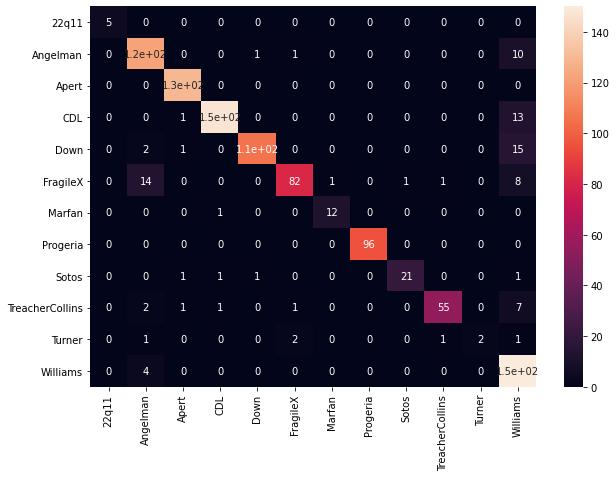

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred, normalize=False) / float(y_test.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_test,y_pred)

accuracy 0.5064102564102564


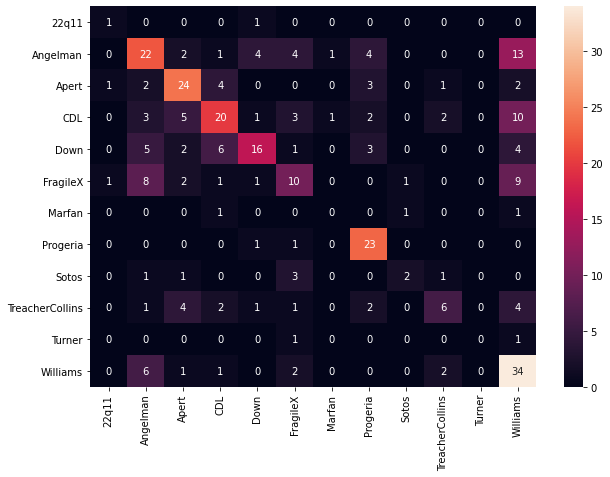

In [16]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

PCA SVM

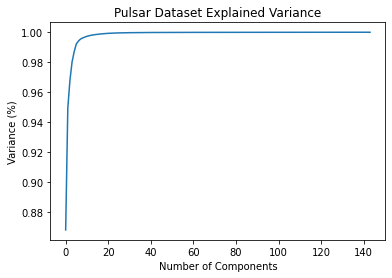

In [17]:
import numpy as np
from sklearn.decomposition import PCA 

pca = PCA().fit(X_train)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [19]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0, tol=1e-5, max_iter=10000)
clf.fit(X_train_pca, y_train)
print(clf.coef_)
print(clf.intercept_)

[[ 6.56266758e-05 -5.13632400e-04  3.20089991e-04 -2.34976509e-04
   7.55441042e-04 -1.00097563e-04  8.60204203e-04 -1.85628401e-04
  -4.91891172e-04  2.69005058e-04 -2.57098210e-04 -5.49959853e-04
   8.65933212e-05  3.59170753e-04  2.78000284e-04]
 [-4.43361281e-04  1.93909778e-03  8.31329512e-04  2.59607122e-03
   1.45830484e-02 -2.00564743e-02 -6.77590289e-03  2.45144880e-02
   7.35769159e-03 -1.47551864e-02  2.86474112e-03 -1.18678457e-03
  -9.90194374e-03  5.47858012e-02 -8.09640446e-03]
 [-2.02067253e-03  1.23496361e-03 -1.40285409e-04 -1.53591244e-02
  -1.56338054e-02  8.91785449e-03 -2.87037278e-02  6.72968075e-03
   5.29698372e-02 -4.55663883e-02  5.09673547e-02  7.59291049e-03
  -1.84222093e-03  2.50019920e-02 -7.38776522e-03]
 [ 1.89355705e-03 -3.54155913e-03  2.00663928e-03 -1.17032816e-02
  -9.98803376e-03  5.63658526e-03  1.41320564e-02 -6.38856232e-03
   9.28508532e-03  2.85536612e-02 -2.19535315e-02  3.78898052e-02
   1.20278426e-02 -3.06558076e-02 -1.74854893e-02]
 [-3

/home/curt/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_train_pca)

accuracy = accuracy_score(y_train, y_pred, normalize=False) / float(y_train.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_train,y_pred)

accuracy 0.46236559139784944


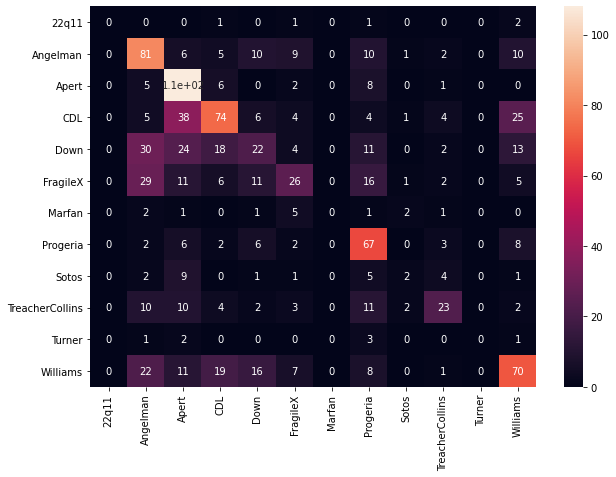

In [21]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred, normalize=False) / float(y_test.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_test,y_pred)

accuracy 0.40384615384615385


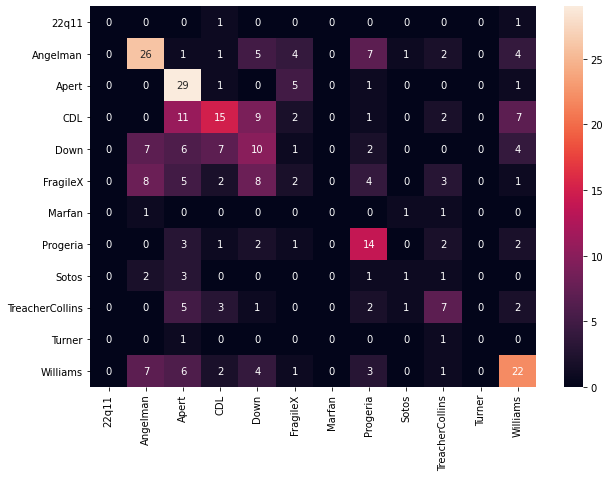

In [23]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

PCA Neural Network

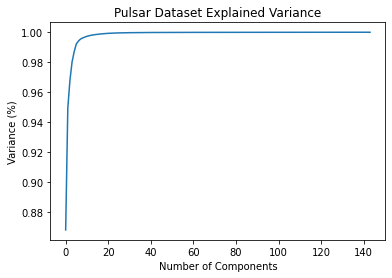

In [24]:
import numpy as np
from sklearn.decomposition import PCA 

pca = PCA().fit(X_train)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [26]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(100, 50), max_iter=2000, verbose=True, n_iter_no_change=500)
clf.fit(X_train_pca, y_train)

Iteration 1, loss = 31.56868534
Iteration 2, loss = 16.10329301
Iteration 3, loss = 9.76705541
Iteration 4, loss = 7.64053242
Iteration 5, loss = 6.13000536
Iteration 6, loss = 5.09063231
Iteration 7, loss = 4.47791367
Iteration 8, loss = 3.78263354
Iteration 9, loss = 3.58838044
Iteration 10, loss = 3.09268806
Iteration 11, loss = 2.98701031
Iteration 12, loss = 2.70202226
Iteration 13, loss = 2.55163360
Iteration 14, loss = 2.39583212
Iteration 15, loss = 2.29810414
Iteration 16, loss = 2.19477053
Iteration 17, loss = 2.07575209
Iteration 18, loss = 2.07350130
Iteration 19, loss = 2.00688863
Iteration 20, loss = 1.90062934
Iteration 21, loss = 1.85086898
Iteration 22, loss = 1.83161993
Iteration 23, loss = 1.76857400
Iteration 24, loss = 1.68877519
Iteration 25, loss = 1.67843429
Iteration 26, loss = 1.85042319
Iteration 27, loss = 1.73649854
Iteration 28, loss = 1.77238031
Iteration 29, loss = 1.64241096
Iteration 30, loss = 1.56312182
Iteration 31, loss = 1.60776202
Iteration 32, l

Iteration 254, loss = 0.38712364
Iteration 255, loss = 0.38901017
Iteration 256, loss = 0.38479353
Iteration 257, loss = 0.41765463
Iteration 258, loss = 0.40939809
Iteration 259, loss = 0.40547486
Iteration 260, loss = 0.40799779
Iteration 261, loss = 0.40001857
Iteration 262, loss = 0.39260029
Iteration 263, loss = 0.40405342
Iteration 264, loss = 0.40868839
Iteration 265, loss = 0.39887788
Iteration 266, loss = 0.38757318
Iteration 267, loss = 0.36784129
Iteration 268, loss = 0.37560751
Iteration 269, loss = 0.37796745
Iteration 270, loss = 0.38366248
Iteration 271, loss = 0.39982087
Iteration 272, loss = 0.39736321
Iteration 273, loss = 0.38242428
Iteration 274, loss = 0.36955185
Iteration 275, loss = 0.36790656
Iteration 276, loss = 0.37267492
Iteration 277, loss = 0.37345596
Iteration 278, loss = 0.41843116
Iteration 279, loss = 0.43273249
Iteration 280, loss = 0.39338309
Iteration 281, loss = 0.38855914
Iteration 282, loss = 0.39050912
Iteration 283, loss = 0.34616990
Iteration 

Iteration 513, loss = 0.17523416
Iteration 514, loss = 0.16091760
Iteration 515, loss = 0.14498697
Iteration 516, loss = 0.14413291
Iteration 517, loss = 0.13768435
Iteration 518, loss = 0.14905594
Iteration 519, loss = 0.14522617
Iteration 520, loss = 0.16302344
Iteration 521, loss = 0.15303764
Iteration 522, loss = 0.14919391
Iteration 523, loss = 0.14773174
Iteration 524, loss = 0.18392682
Iteration 525, loss = 0.14842092
Iteration 526, loss = 0.14477619
Iteration 527, loss = 0.14885706
Iteration 528, loss = 0.17924078
Iteration 529, loss = 0.20077085
Iteration 530, loss = 0.16450953
Iteration 531, loss = 0.16747061
Iteration 532, loss = 0.16388886
Iteration 533, loss = 0.15325049
Iteration 534, loss = 0.14546852
Iteration 535, loss = 0.13854647
Iteration 536, loss = 0.16032473
Iteration 537, loss = 0.14658618
Iteration 538, loss = 0.15092335
Iteration 539, loss = 0.13710318
Iteration 540, loss = 0.13230138
Iteration 541, loss = 0.13400422
Iteration 542, loss = 0.13051258
Iteration 

Iteration 773, loss = 0.06790140
Iteration 774, loss = 0.06123892
Iteration 775, loss = 0.05906536
Iteration 776, loss = 0.05641257
Iteration 777, loss = 0.05353911
Iteration 778, loss = 0.05321852
Iteration 779, loss = 0.05115047
Iteration 780, loss = 0.06331047
Iteration 781, loss = 0.05035023
Iteration 782, loss = 0.05197800
Iteration 783, loss = 0.06102058
Iteration 784, loss = 0.05642909
Iteration 785, loss = 0.05179551
Iteration 786, loss = 0.05572581
Iteration 787, loss = 0.05353176
Iteration 788, loss = 0.05466450
Iteration 789, loss = 0.04913302
Iteration 790, loss = 0.04497752
Iteration 791, loss = 0.04693688
Iteration 792, loss = 0.04882047
Iteration 793, loss = 0.07392452
Iteration 794, loss = 0.06739177
Iteration 795, loss = 0.05478905
Iteration 796, loss = 0.05109350
Iteration 797, loss = 0.05155609
Iteration 798, loss = 0.04696216
Iteration 799, loss = 0.04978947
Iteration 800, loss = 0.04832487
Iteration 801, loss = 0.05973811
Iteration 802, loss = 0.05463449
Iteration 

Iteration 1025, loss = 0.03205835
Iteration 1026, loss = 0.02179242
Iteration 1027, loss = 0.01818948
Iteration 1028, loss = 0.02062671
Iteration 1029, loss = 0.01618901
Iteration 1030, loss = 0.01819452
Iteration 1031, loss = 0.01465076
Iteration 1032, loss = 0.01634625
Iteration 1033, loss = 0.01555840
Iteration 1034, loss = 0.02073946
Iteration 1035, loss = 0.01853338
Iteration 1036, loss = 0.02432141
Iteration 1037, loss = 0.01991722
Iteration 1038, loss = 0.01590687
Iteration 1039, loss = 0.01422013
Iteration 1040, loss = 0.01349860
Iteration 1041, loss = 0.01371779
Iteration 1042, loss = 0.02235088
Iteration 1043, loss = 0.01528530
Iteration 1044, loss = 0.01511092
Iteration 1045, loss = 0.01395339
Iteration 1046, loss = 0.01367688
Iteration 1047, loss = 0.01558102
Iteration 1048, loss = 0.01466445
Iteration 1049, loss = 0.01489863
Iteration 1050, loss = 0.01255982
Iteration 1051, loss = 0.01300852
Iteration 1052, loss = 0.01335906
Iteration 1053, loss = 0.01345594
Iteration 1054

Iteration 1266, loss = 0.00509161
Iteration 1267, loss = 0.00479238
Iteration 1268, loss = 0.00494046
Iteration 1269, loss = 0.00604314
Iteration 1270, loss = 0.00574522
Iteration 1271, loss = 0.00561187
Iteration 1272, loss = 0.00528528
Iteration 1273, loss = 0.00531211
Iteration 1274, loss = 0.00561775
Iteration 1275, loss = 0.00555250
Iteration 1276, loss = 0.01367007
Iteration 1277, loss = 0.00822811
Iteration 1278, loss = 0.00650356
Iteration 1279, loss = 0.00525529
Iteration 1280, loss = 0.00489617
Iteration 1281, loss = 0.00489068
Iteration 1282, loss = 0.00467738
Iteration 1283, loss = 0.00462478
Iteration 1284, loss = 0.00452156
Iteration 1285, loss = 0.00449705
Iteration 1286, loss = 0.00471584
Iteration 1287, loss = 0.00517947
Iteration 1288, loss = 0.00487237
Iteration 1289, loss = 0.00476200
Iteration 1290, loss = 0.00481221
Iteration 1291, loss = 0.00519925
Iteration 1292, loss = 0.00504266
Iteration 1293, loss = 0.00486433
Iteration 1294, loss = 0.00455525
Iteration 1295

Iteration 1511, loss = 0.01139015
Iteration 1512, loss = 0.10374243
Iteration 1513, loss = 0.52938553
Iteration 1514, loss = 1.13554193
Iteration 1515, loss = 1.18206804
Iteration 1516, loss = 1.57152011
Iteration 1517, loss = 1.28381727
Iteration 1518, loss = 1.09912152
Iteration 1519, loss = 1.13529612
Iteration 1520, loss = 1.09935009
Iteration 1521, loss = 0.47837156
Iteration 1522, loss = 0.44090344
Iteration 1523, loss = 0.36578472
Iteration 1524, loss = 0.20798354
Iteration 1525, loss = 0.12146602
Iteration 1526, loss = 0.13741506
Iteration 1527, loss = 0.38918999
Iteration 1528, loss = 0.72050863
Iteration 1529, loss = 0.49388855
Iteration 1530, loss = 0.19360742
Iteration 1531, loss = 0.20306191
Iteration 1532, loss = 0.11014053
Iteration 1533, loss = 0.04665179
Iteration 1534, loss = 0.07443993
Iteration 1535, loss = 0.07035145
Iteration 1536, loss = 0.06193149
Iteration 1537, loss = 0.08432213
Iteration 1538, loss = 0.04841868
Iteration 1539, loss = 0.05895660
Iteration 1540

Iteration 1752, loss = 0.00227296
Iteration 1753, loss = 0.00228783
Iteration 1754, loss = 0.00222821
Iteration 1755, loss = 0.00215665
Iteration 1756, loss = 0.00214218
Iteration 1757, loss = 0.00208661
Iteration 1758, loss = 0.00210654
Iteration 1759, loss = 0.00204655
Iteration 1760, loss = 0.00206321
Iteration 1761, loss = 0.00206035
Iteration 1762, loss = 0.00205888
Iteration 1763, loss = 0.00206639
Iteration 1764, loss = 0.00211776
Iteration 1765, loss = 0.00215416
Iteration 1766, loss = 0.00227243
Iteration 1767, loss = 0.00222808
Iteration 1768, loss = 0.00286079
Iteration 1769, loss = 0.00599471
Iteration 1770, loss = 0.00410719
Iteration 1771, loss = 0.00384711
Iteration 1772, loss = 0.00230036
Iteration 1773, loss = 0.00230261
Iteration 1774, loss = 0.00237787
Iteration 1775, loss = 0.00222945
Iteration 1776, loss = 0.00214661
Iteration 1777, loss = 0.00207159
Iteration 1778, loss = 0.00213530
Iteration 1779, loss = 0.00227189
Iteration 1780, loss = 0.00212767
Iteration 1781

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=500, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_train_pca)

accuracy = accuracy_score(y_train, y_pred, normalize=False) / float(y_train.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_train,y_pred)

accuracy 1.0


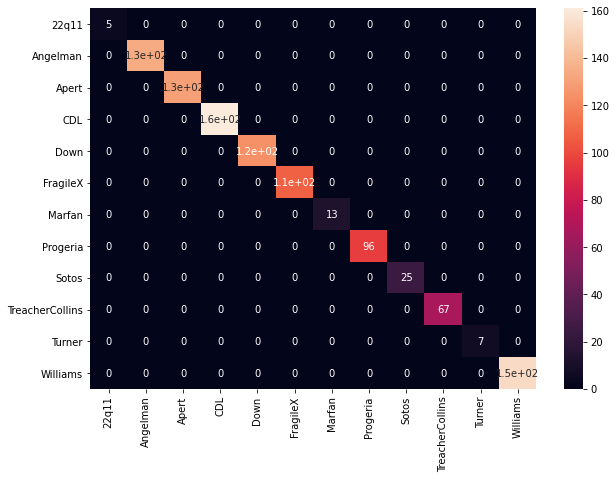

In [28]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


y_pred = clf.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred, normalize=False) / float(y_test.size)
print('accuracy',accuracy)

conf = confusion_matrix(y_test,y_pred)

accuracy 0.42948717948717946


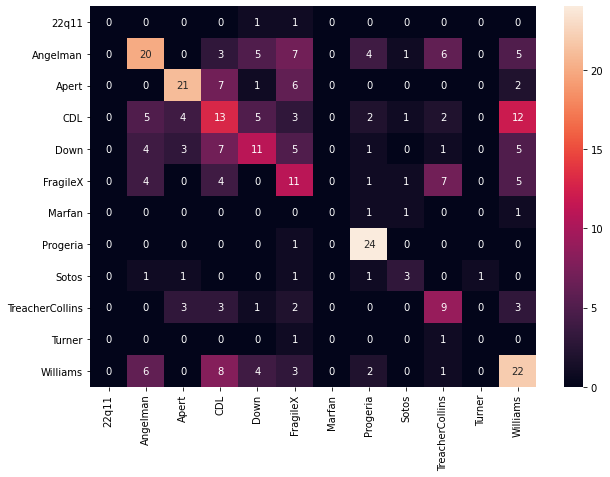

In [30]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf, index = [i for i in LABELS],
                  columns = [i for i in LABELS])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)